# **Deep Learning for Stock Prices**
#### Using Long Short-Term Memory 
---

### Import Dependencies 

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from alpha_vantage.timeseries import TimeSeries 

print("All Libraries Loaded")

All Libraries Loaded


### Configure Basic Parameters 

In [2]:
config = {
    "alpha_vantage": {
        "key": "ALPHA_VANTAGE_API_KEY", 
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "4. close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # only using close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", 
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

### Download Data

In [3]:
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

In [4]:
data_date, data_close_price, num_data_points, display_date_range = download_data(config)

Number data points 5625 from 1999-11-01 to 2022-03-09


### Plot

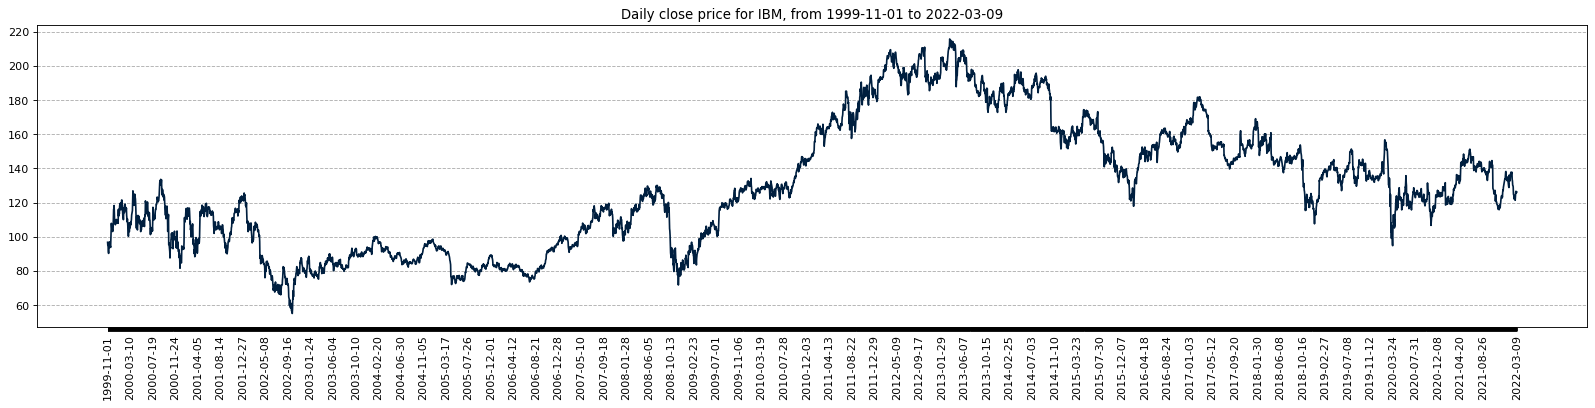

In [5]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])

# xtick data point per pre-selected interval 
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 
                            and (num_data_points-i) > config["plots"]["xticks_interval"]) 
                           or i==num_data_points-1) 
          else None for i in range(num_data_points)] 
x = np.arange(0,len(xticks))


plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show();

In [8]:
yesterday_close = data_close_price[num_data_points-1]
yesterday_date = data_date[num_data_points-1]

print(f"{yesterday_date}: {yesterday_close}")

2022-03-09: 126.22


---
# Data Preparation: Generate Training and Validation Data Sets 
---

### Z-Score Normalization 

In [9]:
class Normalizer():
    def __init__(self):
        self.mu = None # mean
        self.sd = None # standard deviation 

    def fit_transform(self, x):
        # keepdims keeps output the way we want it 
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        # Z-Score Normalization 
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

In [10]:
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

### Prepare Data

In [11]:
# shape of x = (number of rows, sequence of prices)
def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    # x.strides: tuple of bytes to step in each dimension when traversing an array 
        # how many bytes to skip in memory to move to the next position 
    # lib.stride_ticks.as_strided: create view into the array with given shape and strides 
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]

# shape of y = (number of rows, )
def prepare_data_y(x, window_size):
    # Simple Moving Average 
    # np.convolve(one-dimensional input, second one-dimensional input, mode='valid')
    # valid: returns output of the length
    # returns linear convolution of two one-dimensional arrays 
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size    
    
    # move window size over one so different than training data 
    output = x[window_size:]
    return output

In [12]:
data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

### Split Dataset

In [13]:
split_index = int(data_y.shape[0]*config["data"]["train_split_size"])

data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]

data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

### Prepare Data for Plotting

In [14]:
# np.zeros(shape) -> returns new aray of given shape and type with zeros 
to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

# inverse transform -> insert X values into applicable ranges
to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

# np.where(condition,when true,when false) -> returns ndarray or tuple of ndarrays 
to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

### Plot 

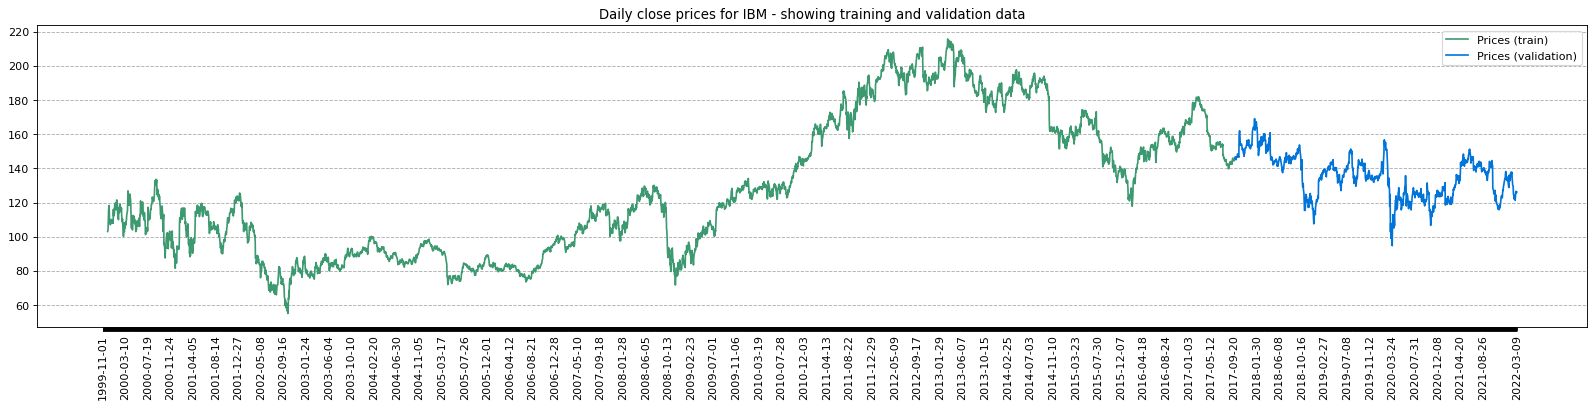

In [15]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))


plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])


xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 
                            and (num_data_points-i) > config["plots"]["xticks_interval"]) 
                           or i==num_data_points-1) 
          else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))


plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show();

### DataLoader
- data generation scheme leveraging computers GPU during training 
- requires Dataset object to define loaded data 
- Dataset: map-style dataset from indices to data samples 

In [16]:
class TimeSeriesDataset(Dataset):
    
    def __init__(self,x,y):
        # only have one feature, convert 'x' into [batch, sequence, features] for LTSM
        # np.expand_dims(input array, axis(or axes)): expand the shape of an aray 
        x = np.expand_dims(x,2)
        # each value in np.array is a float size of 32 bits 
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        return (self.x[idx], self.y[idx])

In [17]:
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (4484, 20, 1) (4484,)
Validation data shape (1121, 20, 1) (1121,)


In [18]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle = True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle = True)

---
# LSTM Model 
---
- linear layer 1 (`linear_1`): map input values into a high dimensional feature space 
    - transforming features for LTSM layer
- LSTM (`lstm`): to learn the data in sequence
- linear layer 2 (`linear_2`): produce the predicted value based on LTSM's output 
- Dropout: randomly selected neurons ignored during training 
    - prevent overfitting 

In [19]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size = 1, hidden_layer_size = 32, num_layers = 2, output_size = 1, dropout = 0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size = self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers * hidden_layer_size, output_size)
        
        self.init_weights()
        
    
    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
    def forward(self,x):
        batchsize = x.shape[0]
        
        #layer1
        x = self.linear_1(x)
        x = self.relu(x)
        #lstm
        lstm_out, (h_n, c_n) = self.lstm(x)
        #reshape output from hidden cell into [batch, features] for linear 2 
        x = h_n.permute(1,0,2).reshape(batchsize, -1)
        #layer2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

---
# Model Training
---
- LSTM runs iteratively making predictions given training data `x`
- MSE = cost function: measures diff between predicted and actual values 
    - high MSE = model making bad predictions 
- Backpropagation: backtracking to improve predictions 
- Adam Optimizer: updates parameters based on learning rate through `step()` method 
    - fine tuning 
- StepLR Scheduler: reduce learning rate during training process 
    - also ReduceLROnPlateau

In [20]:
# resolves: OMP: Error #15: Initializing libiomp5.dylib, but found libomp.dylib already initialized.

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [21]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0 
    if is_training:
        model.train()
    else:
        model.eval()
        
    for idx, (x,y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()
        batchsize = x.shape[0]
        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])
        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())
        
        if is_training: 
            loss.backward()
            optimizer.step()
        
        epoch_loss += (loss.detach().item() / batchsize)
    
    lr = scheduler.get_last_lr()[0]
    return epoch_loss, lr

In [22]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

In [23]:
model = LSTMModel(input_size = config["model"]["input_size"], 
                  hidden_layer_size = config["model"]["lstm_size"], 
                  num_layers = config["model"]["num_lstm_layers"], 
                  output_size = 1, 
                  dropout = config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9,0.98), eps = 1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = config["training"]["scheduler_step_size"], gamma=0.1)

In [25]:
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training = True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train: {:.6f}, test: {:.6f} | lr: {:.6f}'.format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train: 0.075161, test: 0.001823 | lr: 0.010000
Epoch[2/100] | loss train: 0.020869, test: 0.002504 | lr: 0.010000
Epoch[3/100] | loss train: 0.015774, test: 0.001419 | lr: 0.010000
Epoch[4/100] | loss train: 0.019844, test: 0.002237 | lr: 0.010000
Epoch[5/100] | loss train: 0.016534, test: 0.001452 | lr: 0.010000
Epoch[6/100] | loss train: 0.017622, test: 0.001680 | lr: 0.010000
Epoch[7/100] | loss train: 0.022091, test: 0.001394 | lr: 0.010000
Epoch[8/100] | loss train: 0.018530, test: 0.002343 | lr: 0.010000
Epoch[9/100] | loss train: 0.013674, test: 0.001274 | lr: 0.010000
Epoch[10/100] | loss train: 0.012839, test: 0.001658 | lr: 0.010000
Epoch[11/100] | loss train: 0.013890, test: 0.001325 | lr: 0.010000
Epoch[12/100] | loss train: 0.016852, test: 0.001346 | lr: 0.010000
Epoch[13/100] | loss train: 0.013240, test: 0.001502 | lr: 0.010000
Epoch[14/100] | loss train: 0.014173, test: 0.001472 | lr: 0.010000
Epoch[15/100] | loss train: 0.018829, test: 0.001327 | lr

---
# Model Evaluation 
---

In [26]:
# Re-initialize dataloder so data isn't shuffled and we can plot values by date 
train_dataloader = DataLoader(dataset_train, batch_size = config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size = config["training"]["batch_size"], shuffle=False)

model.eval()

LSTMModel(
  (linear_1): Linear(in_features=1, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)

### Predict on training Data

In [27]:
# validation 
predicted_val = np.array([])

for idx, (x,y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# training
predicted_train = np.array([])
    
for idx, (x,y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

### Prepare Data

In [28]:
plot_data_y_train_pred = np.zeros(num_data_points)
plot_data_y_val_pred = np.zeros(num_data_points)

plot_data_y_train_pred[config["data"]["window_size"] : split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

plot_data_y_train_pred = np.where(plot_data_y_train_pred==0, None, plot_data_y_train_pred)
plot_data_y_val_pred = np.where(plot_data_y_val_pred==0, None, plot_data_y_val_pred)

### Plot

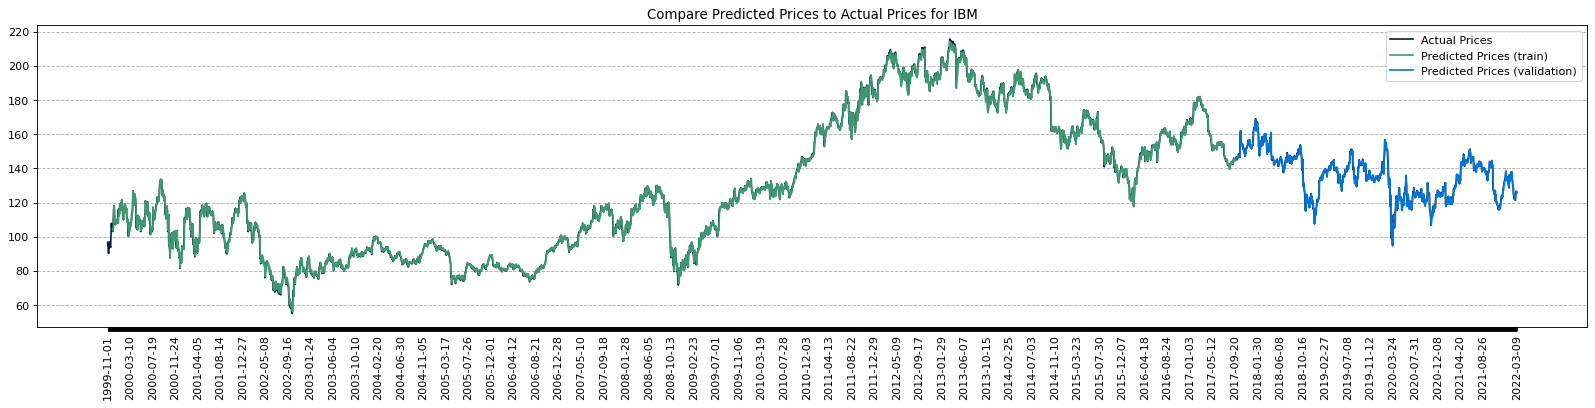

In [29]:
fig = figure(figsize=(25,5),dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(data_date, data_close_price, label="Actual Prices", color=config["plots"]["color_actual"])
plt.plot(data_date, plot_data_y_train_pred, label="Predicted Prices (train)", color = config["plots"]["color_pred_train"])
plt.plot(data_date, plot_data_y_val_pred, label="Predicted Prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare Predicted Prices to Actual Prices for " + config["alpha_vantage"]["symbol"])

xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0
                          and (num_data_points-i) > config["plots"]["xticks_interval"])
                          or i == num_data_points- 1)
                          else None for i in range(num_data_points)]
x = np.arange(0,len(xticks))

plt.xticks(x, xticks, rotation='vertical')
plt.grid(b=None, which = 'major', axis = 'y', linestyle = '--')
plt.legend()
plt.show();

- model has managed to learn and predict on both training (green) and validation(blue) datasets
- predicted prices lines significantly overlap with actual prices 

### Generate Zoomed-In Plot

In [30]:
plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
plot_predicted_val = scaler.inverse_transform(predicted_val)
plot_data_date = data_date[split_index+config["data"]["window_size"]:]

### Plot

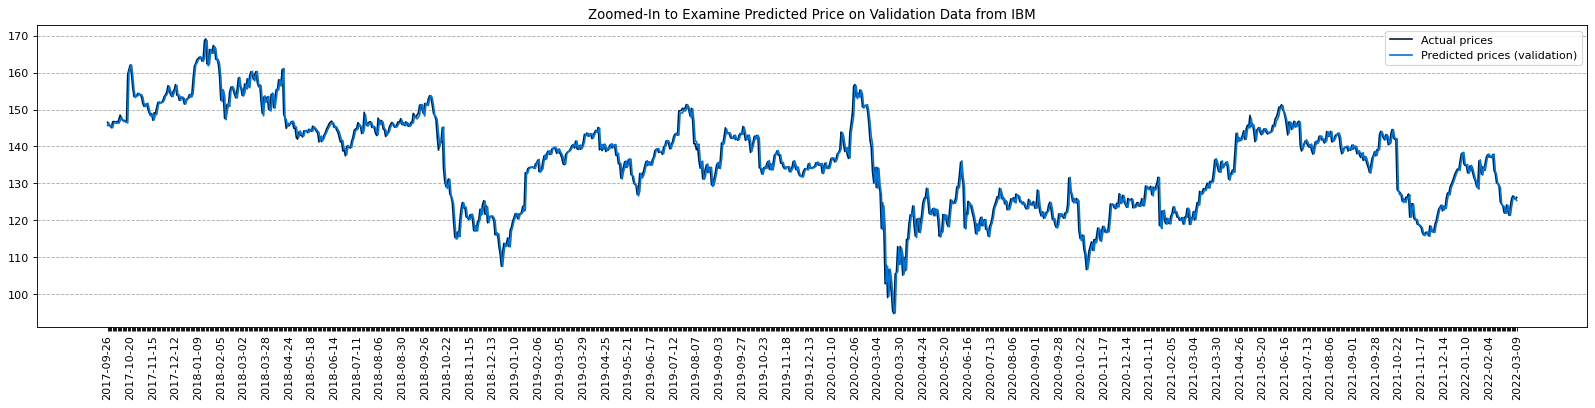

In [31]:
fig = figure(figsize=(25,5),dpi=80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(plot_data_date, plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(plot_data_date, plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoomed-In to Examine Predicted Price on Validation Data from " + config["alpha_vantage"]["symbol"])

xtickss = [plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0
                                 and (len(plot_data_date)-i) > config["plots"]["xticks_interval"]/6) 
                                or i==len(plot_data_date)-1)
                              else None for i in range(len(plot_data_date))]
xs = np.arange(0,len(xtickss))

plt.xticks(xs, xtickss, rotation='vertical')
plt.grid(b = None, which = 'major', axis = 'y', linestyle = '--')
plt.legend()
plt.show();

---
# Predicting Future Stock Prices 
---
- predict next day's price based on past 20 days' close prices

### Predict Closing Price 

In [32]:
model.eval()

# data type and shape required [batch, sequence, feature]
x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2)
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
print(prediction)

[-0.09174998]


### Prepare Data

In [33]:
plot_range = 10

plot_data_y_val = np.zeros(plot_range)
plot_data_y_val_pred = np.zeros(plot_range)
plot_data_y_test_pred = np.zeros(plot_range)

plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]
plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

plot_data_y_val = np.where(plot_data_y_val==0, None, plot_data_y_val)
plot_data_y_val_pred = np.where(plot_data_y_val_pred==0, None, plot_data_y_val_pred)
plot_data_y_test_pred = np.where(plot_data_y_test_pred==0, None, plot_data_y_test_pred)

### Plot

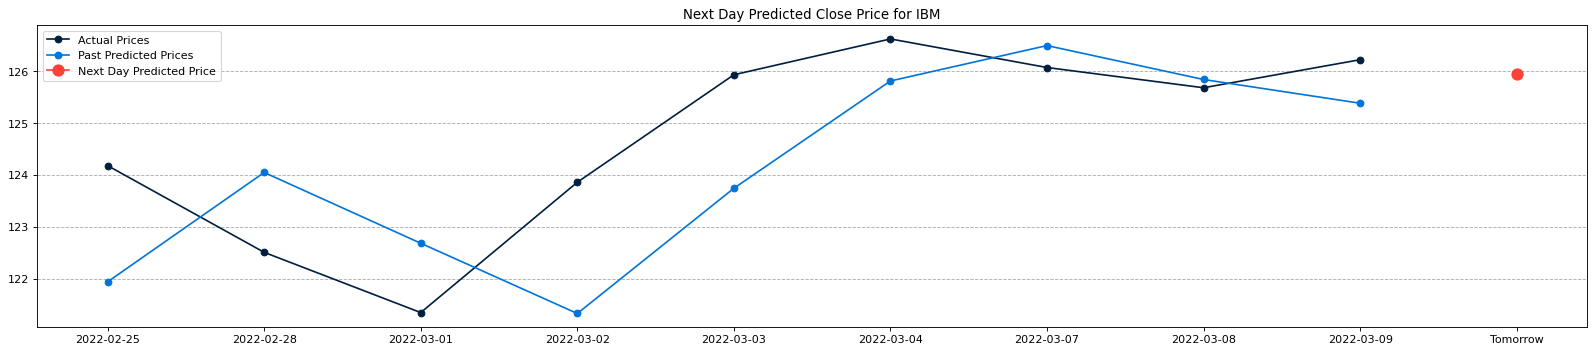

Predicted close price of the next trading day:  125.95


In [34]:
plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("Tomorrow")

fig = figure(figsize=(25,5), dpi = 80)
fig.patch.set_facecolor((1.0,1.0,1.0))

plt.plot(plot_date_test, plot_data_y_val, label="Actual Prices", marker=".", markersize=12, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, plot_data_y_val_pred, label="Past Predicted Prices", marker=".", markersize=12, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, plot_data_y_test_pred, label="Next Day Predicted Price", marker=".", markersize=20, color=config["plots"]["color_pred_test"])

plt.title("Next Day Predicted Close Price for " + config["alpha_vantage"]["symbol"])
plt.grid(b=None, which = 'major', axis = 'y', linestyle = '--')
plt.legend(loc=2)
plt.show();

print("Predicted close price of the next trading day: ", round(plot_data_y_test_pred[plot_range-1],2))